## Lab 5 - Using link functions to create generalized linear models
<br>
Dominik Czyżyk<br>
401858<br>
czwartek, 9:30

In [2]:
from cmdstanpy import CmdStanModel

import arviz as az
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
import pandas as pd

/usr/local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
pd_data = pd.read_csv('Airline_data.csv')
pd_data.head()

,Year,Fatal accidents,Passenger deaths,Miles flown [100 mln miles]
0,1976,24,734,3863.0
1,1977,25,516,4300.0
2,1978,31,754,5027.0
3,1979,31,877,5481.0
4,1980,22,814,5814.0


In [5]:
pd_data.describe()

,Year,Fatal accidents,Passenger deaths,Miles flown [100 mln miles]
count,10.00000,10.000000,10.000000,10.000000
mean,1980.50000,23.800000,691.900000,5715.800000
std,3.02765,4.709329,252.389228,1117.767795
min,1976.00000,16.000000,223.000000,3863.000000
25%,1978.25000,21.250000,570.500000,5140.500000
50%,1980.50000,23.000000,759.000000,5845.500000
75%,1982.75000,25.750000,812.750000,6175.500000
max,1985.00000,31.000000,1066.000000,7433.000000


### Check prior value

INFO:cmdstanpy:compiling stan file /home/Lab5/ppc_check.stan to exe file /home/Lab5/ppc_check
INFO:cmdstanpy:compiled model executable: /home/Lab5/ppc_check
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


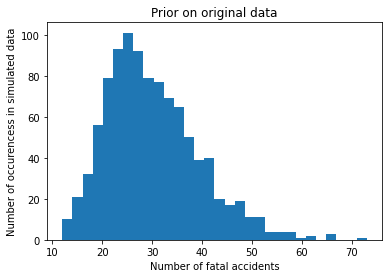

In [6]:
ppc_check=CmdStanModel(stan_file='ppc_check.stan')

check = ppc_check.sample(seed=19042023,
                      fixed_param=True,
                      iter_sampling=1000, 
                      iter_warmup=0,
                      chains=1)
check_pd = check.draws_pd()

check_pd['y_sim'].plot.hist(bins=30)
plt.title("Prior on original data")
plt.xlabel("Number of fatal accidents")
plt.ylabel("Number of occurencess in simulated data")
plt.show()

From above graph we can see that priors are okay. They allow some outliers but mostly are close to 'sane' values of accidents. <br>

Such large data was giving errors in posterior distribution, so to stop it I decided to scale it down by 10,000 to get unit of trillion passenger miles.

#### Prior tuning

INFO:cmdstanpy:compiling stan file /home/Lab5/ppc_tune.stan to exe file /home/Lab5/ppc_tune


Mean of new miles: 0.57158


INFO:cmdstanpy:compiled model executable: /home/Lab5/ppc_tune
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


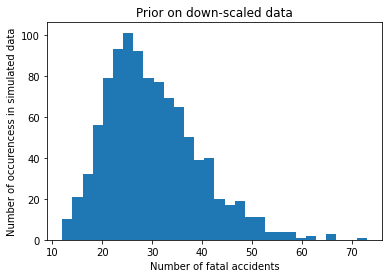

In [7]:
pd_data["Miles flown [100 mln miles]"] = pd_data["Miles flown [100 mln miles]"] / 10000
print(f'Mean of new miles: {pd_data["Miles flown [100 mln miles]"].mean()}')

ppc_tune=CmdStanModel(stan_file='ppc_tune.stan')

tuned = ppc_tune.sample(seed=19042023,
                      fixed_param=True,
                      iter_sampling=1000, 
                      iter_warmup=0,
                      chains=1)
tuned_pd = tuned.draws_pd()

tuned_pd['y_sim'].plot.hist(bins=30)
plt.title("Prior on down-scaled data")
plt.xlabel("Number of fatal accidents")
plt.ylabel("Number of occurencess in simulated data")
plt.show()

### Posterior modeling


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▍         | 00:00 Status
chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       

INFO:cmdstanpy:CmdStan done processing.


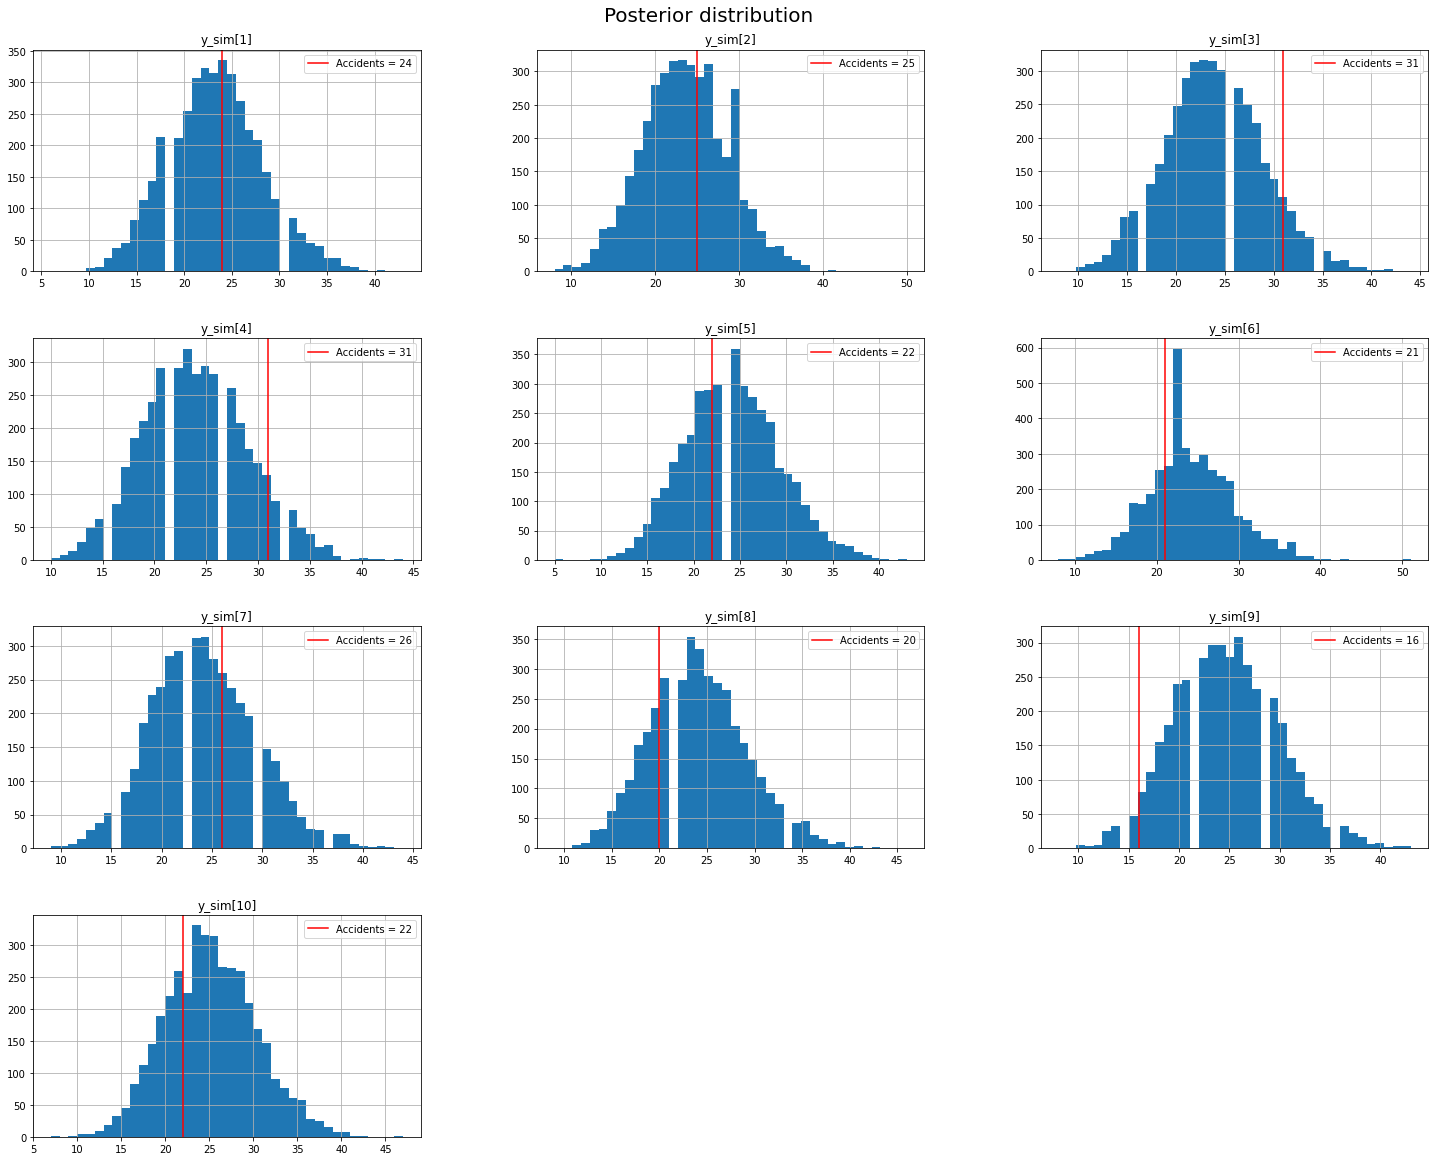

In [14]:
posterior=CmdStanModel(stan_file='posterior_one_alpha.stan')

data = {"M": len(pd_data), "miles": pd_data["Miles flown [100 mln miles]"].values, "y": pd_data["Fatal accidents"].values}
posterior_one = posterior.sample(data=data)
posterior_one_pd = posterior_one.draws_pd()

axes = posterior_one_pd.iloc[:,9:].hist(figsize=(25,20), bins=40)
axes = axes.ravel()
for idx,ax in enumerate(axes):
    if idx < 10:
        ax.axvline(pd_data["Fatal accidents"][idx], color='red', label=f'Accidents = {pd_data["Fatal accidents"][idx]}')
        ax.legend()
plt.suptitle("Posterior distribution", y=0.91, fontsize=20)
plt.show()

From posterior we can see that its mean values don't differ that much. This could result in bad generalisation for future data.

#### Multiple alpha parameters

INFO:cmdstanpy:compiling stan file /home/Lab5/posterior_multi_alpha.stan to exe file /home/Lab5/posterior_multi_alpha
INFO:cmdstanpy:compiled model executable: /home/Lab5/posterior_multi_alpha
--- Translating Stan model to C++ code ---
bin/stanc  --o=/home/Lab5/posterior_multi_alpha.hpp /home/Lab5/posterior_multi_alpha.stan
Warning in '/home/Lab5/posterior_multi_alpha.stan', line 4, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/home/Lab5/posterior_multi_alpha.stan', line 8, column 3: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/home/Lab5/posterior_multi_a

INFO:cmdstanpy:CmdStan done processing.


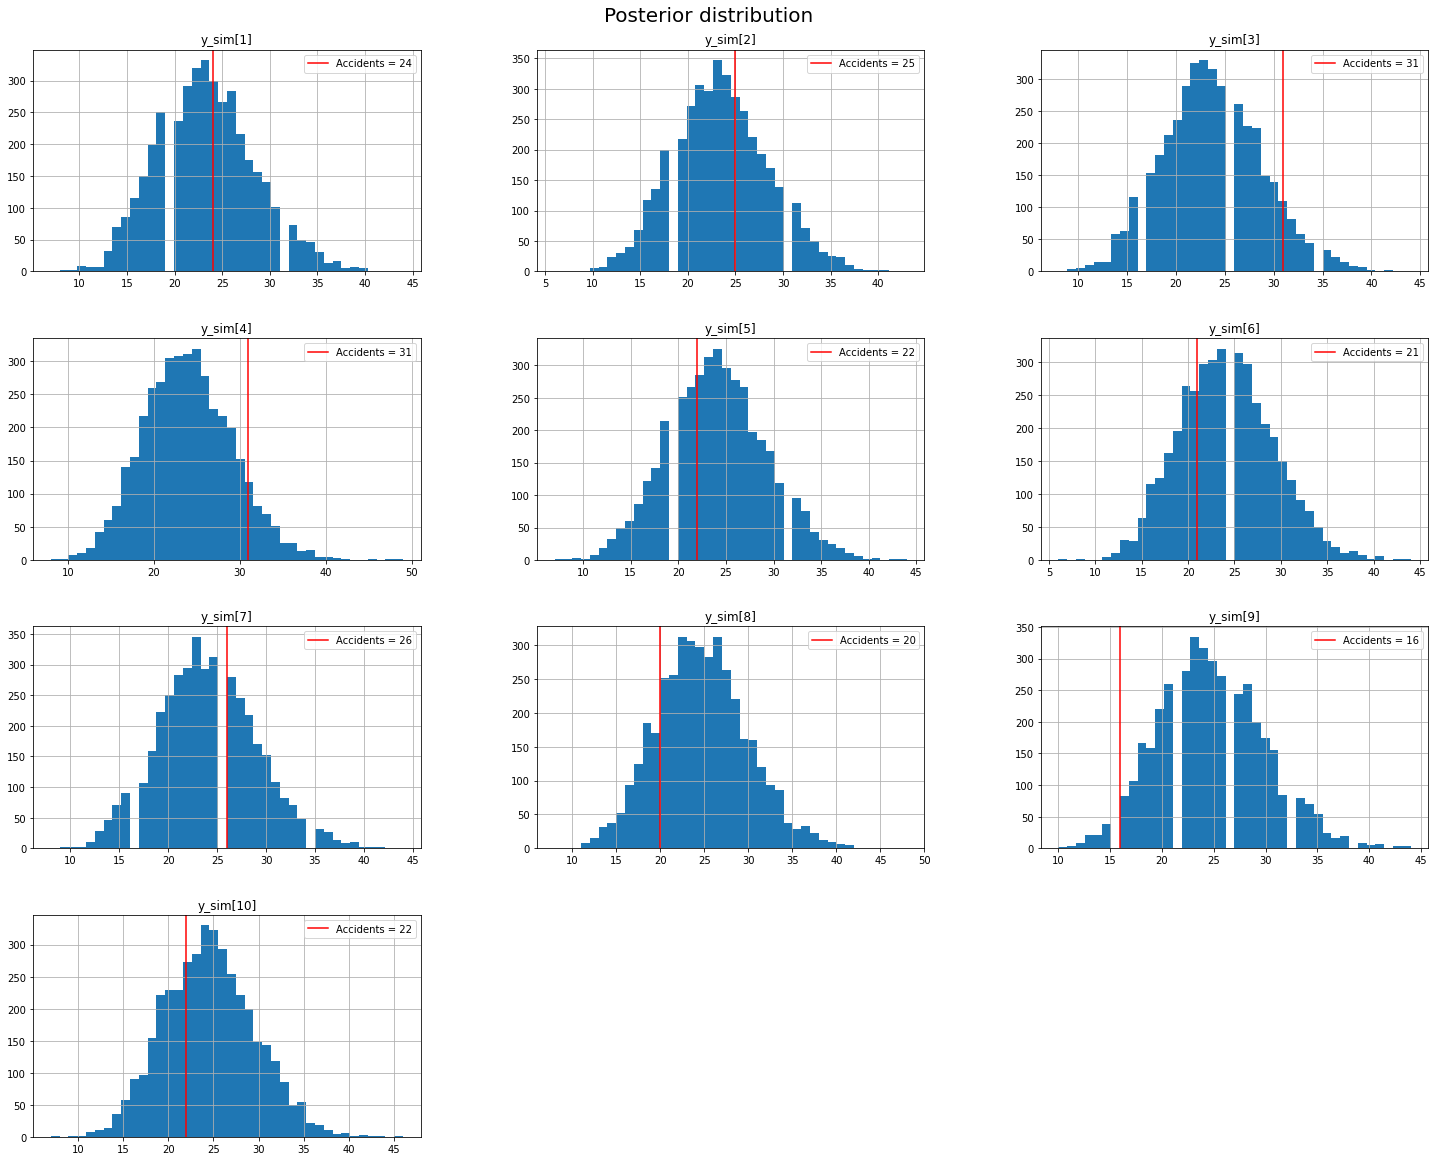

In [17]:
posterior=CmdStanModel(stan_file='posterior_multi_alpha.stan')

data = {"M": len(pd_data), "miles": pd_data["Miles flown [100 mln miles]"].values, "y": pd_data["Fatal accidents"].values}
posterior_multi = posterior.sample(data=data)
posterior_multi_pd = posterior_multi.draws_pd()

axes = posterior_multi_pd.iloc[:,18:].hist(figsize=(25,20), bins=40)
axes = axes.ravel()
for idx,ax in enumerate(axes):
    if idx < 10:
        ax.axvline(pd_data["Fatal accidents"][idx], color='red', label=f'''Accidents = {pd_data["Fatal accidents"][idx]}''')
        ax.legend()
plt.suptitle("Posterior distribution", y=0.91, fontsize=20)
plt.show()

Model is very similar to the previous one.